In [1]:
import torch

if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()
    print(n_gpus, 'CUDA devices')
    gpu_id = torch.cuda.current_device()
    gpu_prop = torch.cuda.get_device_properties(gpu_id)
    print(gpu_prop)
else:
    print('CUDA not available')

1 CUDA devices
_CudaDeviceProperties(name='Quadro K620', major=5, minor=0, total_memory=2048MB, multi_processor_count=3)


1. set up test data
2. set up statistics network
3. train and model


In [4]:
import napari
import xarray as xr

image_path = 'Y:\\Kunal\\HiSeqExperiments\\20210323_4i4color\\zarrs\\m4.zarr'

unmixed_im = xr.open_zarr(image_path).to_array()
unmixed_im = unmixed_im.squeeze().drop_vars('variable').rename('m4_raw')


KeyboardInterrupt: 

In [4]:
unmixed_im

,Array,Chunk
Bytes,37.63 GB,37.63 MB
Shape,"(4, 5, 10, 9187, 10240)","(1, 1, 1, 9187, 2048)"
Count,3001 Tasks,1000 Chunks
Type,uint16,numpy.ndarray


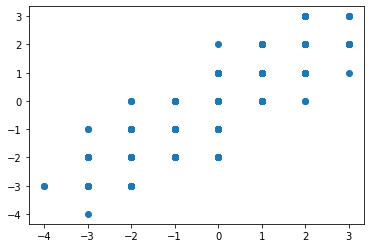

In [175]:
%matplotlib inline

#from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt

def get_joint_samples_torch(correlation, mean = [0,0]):
    """Return 2 arrays with specified correlation."""
    
    mean = np.array(mean)
    mvn = MultivariateNormal(torch.tensor(mean), torch.eye(2)*correlation)
    
    return mvn

def get_joint_samples_np(correlation, size, mean = [0,0], variance = [1,1]):
    """Return 2 arrays with specified correlation."""
    
    cov = [[variance[0], correlation], [correlation, variance[1]]]
    
    mvn = multivariate_normal(mean, cov, size = size)
    
    x = mvn[:,0].astype('int16')
    y = mvn[:,1].astype('int16')
    
    #pdf = 
    
    return x, y

figure, ax = plt.subplots(1,1)
x, y = get_joint_samples_np(1,10000, variance=[1.1,1.1])
#ax.scatter(mvn.sample((1000,)))
ax.scatter(x, y)


In [168]:
import picasso
import importlib
importlib.reload(picasso)
from picasso import *

x, y = get_joint_samples_np(-1,10, mean=[0,1], variance=[2,2])
mutual_information(x,y)

[[0.  0.  0.  0.1 0. ]
 [0.  0.  0.1 0.  0. ]
 [0.  0.  0.3 0.2 0.1]
 [0.  0.  0.1 0.  0. ]
 [0.1 0.  0.  0.  0. ]]
[0.1 0.1 0.6 0.1 0.1]
[0.1 0.  0.5 0.3 0.1]
[3 2 0 2 2 1 2 2 4 2]
[2 3 3 2 4 2 3 2 0 2]
[0.1 0.2 0.1 0.3 0.1 0.1 0.2 0.3 0.1 0.3]
[0.1 0.6 0.1 0.6 0.6 0.1 0.6 0.6 0.1 0.6]
[0.5 0.3 0.3 0.5 0.1 0.5 0.3 0.5 0.1 0.5]


0.5825119944837167

In [181]:
import sys
sys.path.append('C:\\Users\\kpandit\\PICASSO\\picasso\\')
import picasso
import importlib
importlib.reload(picasso)
from picasso import *
import matplotlib.pyplot as plt

correlation = np.linspace(-1,1,100)
#correlation = [0]
n_points = 100000

mi = []
for c in correlation:
    X, Y = get_joint_samples_np(c,n_points)
    mi.append(mutual_information(X,Y))


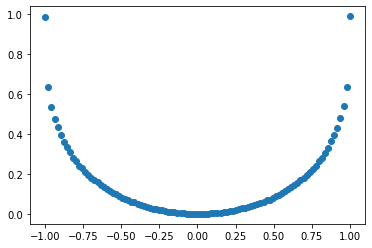

In [182]:
figure, ax = plt.subplots(1,1)
ax.scatter(correlation,mi)

In [ ]:
import torch
from math import floor, ceil

def gpu_mutual_information(X,Y):
    """Compute mutual information between X and Y dask arrays."""

    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
 
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y)
        
    if not X.is_cuda:
        X.to(device)
    if not Y.is_cuda:
        Y.to(device)

    # compute limits
    #X = X.compute()
    xmin = floor(torch.min(X))
    xmax = ceil(torch.max(X))

    #Y = Y.compute()
    ymin = floor(torch.min(Y))
    ymax = ceil(torch.max(Y))

    # reshape for histogram
    XY = torch.stack(torch.flatten(X), torch.flatten(Y))

    # joint probability distribution
    xbins = range(xmin, xmax+2)
    ybins = range(ymin, ymax+2)
    H, edges = da.histogramdd(XY, bins=[xbins, ybins], density = True)
    H = H.compute()

    # x marginal probability distribution
    p_x = H.sum(axis=1)
    # y marginal probability distribution
    p_y = H.sum(axis=0)

    # compute indices
    xi = da.digitize(X,xbins)-1
    yi = da.digitize(Y,ybins)-1

    H_ = da.from_array(H[xi,yi])
    x_ = da.from_array(p_x[xi])
    y_ = da.from_array(p_y[yi])

    # Mutual information I(X,Y)
    try:
        MI=da.sum(H_*da.log(H_/(x_*y_)))
        MI=MI.compute()
    except:
        print('H', H.shape)
        print('px', p_x.shape)
        print('py', p_y.shape)
        print('MI failed',xbins, ybins)
        MI = None

    return MI  

In [58]:
a = torch.rand(4,4)
b = torch.rand(4,4)
print(a.dim())
print(torch.flatten(a).dim())
torch.stack([torch.flatten(a),torch.flatten(b)],dim=1)

2
1


tensor([[0.9697, 0.7958],
        [0.2332, 0.2019],
        [0.4772, 0.0033],
        [0.1294, 0.9575],
        [0.6113, 0.3516],
        [0.6727, 0.0592],
        [0.9245, 0.7286],
        [0.5120, 0.9298],
        [0.2275, 0.0533],
        [0.0889, 0.2279],
        [0.1082, 0.7098],
        [0.4266, 0.8183],
        [0.4020, 0.9590],
        [0.4030, 0.1881],
        [0.2471, 0.4394],
        [0.4332, 0.4228]])

In [39]:
from torch import nn
import math

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class EMALoss(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        EPS = 1e-6
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None


def ema(mu, alpha, past_ema):
    return alpha * mu + (1.0 - alpha) * past_ema


def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = ema(t_exp, alpha, running_mean.item())
    t_log = EMALoss.apply(x, running_mean)

    # Recalculate ema

    return t_log, running_mean

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = CustomSequential(ConcatLayer(), nn.Linear(x_dim + y_dim, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 400),
                                       nn.ReLU(),
                                       nn.Linear(400, 1))

    def forward(self, x, z):
        return self.layers(x, z)
    
class ConcatLayer(nn.Module):
    def __init__(self, dim=0):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        return torch.cat((x, y), self.dim)


class CustomSequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            if isinstance(input, tuple):
                input = module(*input)
            else:
                input = module(input)
        return input

class Mine(nn.Module):
    def __init__(self, T, alpha=0.01):
        super().__init__()
        self.running_mean = 0
        self.alpha = alpha
        self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]
        
        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)

        second_term, self.running_mean = ema_loss(t_marg, self.running_mean, self.alpha)

        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size=1, opt=None):

        
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=1e-4)

        for iter in range(1, iters + 1):
            mu_mi = 0
            for x, y in batch(X, Y):
                opt.zero_grad()
                loss = self.forward(x, y)
                loss.backward()
                opt.step()

                mu_mi -= loss.item()
            if iter % (iters // 3) == 0:
                pass
                #print(f"It {iter} - MI: {mu_mi / batch_size}")

        with torch.no_grad():
            final_mi = -self.forward(x,y)
        print(f"Final MI: {final_mi}")
        
        return final_mi
    
def batch(x, y, batch_size=1, shuffle=True):
    assert len(x) == len(y), "Input and target data must contain same number of elements"
    
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
 
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y).float()
        
    if not x.is_cuda:
        x.to(device)
    if not y.is_cuda:
        y.to(device)

    n = len(x)

    if shuffle:
        rand_perm = torch.randperm(n)
        x = x[rand_perm]
        y = y[rand_perm]

    batches = []
    for i in range(n // batch_size):
        x_b = x[i * batch_size: (i + 1) * batch_size]
        y_b = y[i * batch_size: (i + 1) * batch_size]
        
        batches.append((x_b, y_b))
        
    return batches

Using cuda device


In [221]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from math import log

class MINE(nn.Module):
    def __init__(self, T=None, alpha=0.01):
        super(MINE, self).__init__()
        # weight coefficient for exponential moving average
        # higher alpha discounts older observations faster
        self.alpha = alpha
        # running exponential moving average
        self.running_mean = None
        # statistics network
        if T is None:
            self.T = nn.Sequential(
                nn.Linear(2, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 1),
            )
        else:
            self.T = T
            
        if torch.cuda.is_available():
            n_gpus = torch.cuda.device_count()
            #print(n_gpus, 'CUDA devices')
            gpu_id = torch.cuda.current_device()
            gpu_prop = torch.cuda.get_device_properties(gpu_id)
            #print(gpu_prop)
            self.device = 'cuda'
        else:
            #print('CUDA not available')
            self.device = 'cpu'
        
        print('Using '+self.device)
        self.T.to(self.device)
            
        
    
    def forward(self, xy):
        
        t = self.T(xy).mean()
        
        ymarg = xy[torch.randperm(xy.shape[0]),1]   # estimate marginal by shuffling along batch axis
        xymarg = torch.stack([xy[:,0],ymarg],1)
        t_marg = self.T(xymarg)
        
        #running_mean = self.update_ema(torch.exp(torch.logsumexp(t_marg,0)-log(xy.shape[0])).detach())
        running_mean = self.update_ema(torch.mean(torch.exp(t_marg)).detach())
        
        t_log = MINE_EMA_loss.apply(t_marg, running_mean)
        #t_log = torch.logsumexp(t_marg,0)-log(xy.shape[0])
        
        return -t + t_log # gradient ascent => -loss => -(t-t_log)
    
    def update_ema(self, new_mean):
        if self.running_mean is None:
            self.running_mean = new_mean
        else:
            self.running_mean = self.alpha*new_mean + (1-self.alpha)*self.running_mean
            
        #self.running_mean += 1E-6

        return self.running_mean
    
    def train_loop(self, X, Y, iters, batch_size=500, opt=None):
              
        old_param = self.flatten_parameters()
              
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=1e-4)

        mi = []
        for i in range(1, iters + 1):
            mi_ = 0
            for batch, xy in enumerate(DataLoader(torch.stack([X,Y],1), batch_size, shuffle=True)):
                opt.zero_grad()
                loss = self.forward(xy)
                mi_ += loss.item()
                loss.backward()
                opt.step()

            mi.append(-mi_/(batch+1))
            
            new_param = self.flatten_parameters()
            param_norm = torch.linalg.norm(new_param - old_param)
            old_param = new_param
                      
            if i % (iters // 4) == 0:
                #pass
                print(f"It {i} - MI: {mi[-1]}")
                
            if param_norm.item() < 0.05:
                print(f"Converged in {i} iterations - MI: {mi[-1]}")
                break
                

#         with torch.no_grad():
#             final_mi = -self.forward(xy)
#         print(f"Final MI: {final_mi}")
        
        return mi
    
    def flatten_parameters(self):
        
        p = torch.tensor([],device=self.device)
        
        for param in mine.parameters():
             p = torch.cat([p, param.data.flatten()])
                
        return p
            

class MINE_EMA_loss(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, ema):
        
        ctx.save_for_backward(input)
        ctx.ema = ema
        
        t_lse_mean = input.exp().mean().log()
        
        return t_lse_mean

    @staticmethod
    def backward(ctx, grad_output):
        
        input, = ctx.saved_tensors

        grad = grad_output*torch.exp(input).detach()/ctx.ema/input.shape[0]

        return grad, None 

In [130]:
# from https://github.com/MasanoriYamada/Mine_pytorch/blob/master/mine.ipynb

# data
def func(x, size):
    return x

def gen_x(size):
    return np.sign(np.random.normal(0.,1.,[size,]))

def gen_y(x,var):
    return x+np.random.normal(0.,np.sqrt(var),x.shape)

def mi_actual(x,y, var):
    p_y_x=np.exp(-(y-x)**2/(2*var))
    p_y_x_minus=np.exp(-(y+1)**2/(2*var))
    p_y_x_plus=np.exp(-(y-1)**2/(2*var))
    mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))

    return mi


Actual 0.005453902692617766


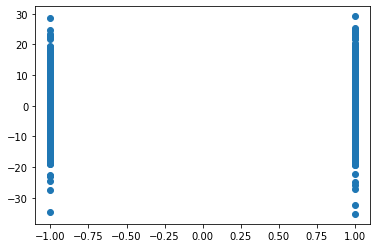

In [92]:
var = 100
X = gen_x(1000)
Y = gen_y(X,var)

figure, ax = plt.subplots(1,1)
ax.scatter(X, Y)

actual = mi_actual(X,Y,var)
print('Actual', actual)

In [ ]:
import sys
sys.path.append('C:\\Users\\kpandit\\PICASSO\\picasso\\')
from picasso import *

X, Y = get_joint_samples_np(1,20000, variance = [1.1,1.1])
actual = mutual_information(X,Y)
# var = 1/100
# X = gen_x(20000)
# Y = gen_y(X,var)
# actual = mi_actual(X,Y,var)
print('Actual', actual)

xs = torch.from_numpy(X).float().cuda()
ys = torch.from_numpy(Y).float().cuda()
mine = MINE()
mi = mine.train_loop(xs,ys, iters=100)
#pred = mine.T(torch.stack([X,Y],1)).mean().item()
#print('Predicted', pred)


Actual 0.4395405735565778
Using cuda


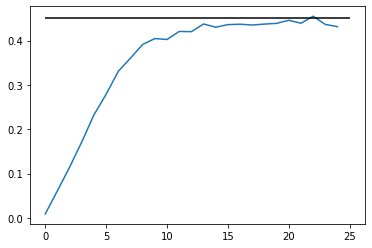

In [219]:
figure, ax = plt.subplots(1,1)
ax.plot(mi)
ax.hlines(actual,0,len(mi),'k')


In [213]:
p = torch.tensor([],device='cuda')
for param in mine.parameters():
    p = torch.cat([p, param.flatten()])
p.shape

torch.Size([10501])

In [203]:
init_mine = MINE()
for param_init, param in zip(init_mine.parameters(), mine.parameters()):
    print(torch.linalg.norm(param_init.data-param.data))

Using cuda
tensor(8.4524, device='cuda:0')
tensor(5.5297, device='cuda:0')
tensor(8.7246, device='cuda:0')
tensor(0.8692, device='cuda:0')
tensor(1.1612, device='cuda:0')
tensor(0.0375, device='cuda:0')


In [78]:
mi_est = []
mi_act = []

n_points = 1000
for c in correlation:
    X, Y = get_joint_samples(c,n_points)
    mi_act.append(mutual_information(X,Y))
    
    X = torch.from_numpy(X).float().cuda()
    Y = torch.from_numpy(Y).float().cuda()
    
    model = NeuralNetwork(1,1).to(device)
    mine = Mine(model)
    mi_est.append(mine.optimize(X, Y, iters = 100).item())
    

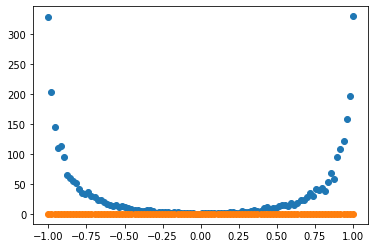

In [79]:
figure, ax = plt.subplots(1,1)
ax.scatter(correlation,mi_act)
ax.scatter(correlation,mi_est)

In [62]:
from torch.utils.data import DataLoader
batches = DataLoader(torch.stack([X,Y],1),256, shuffle=True)